In [445]:
import numpy as np
import gp_cake.simulator as sim
reload(sim)
import matplotlib.pyplot as plt
%matplotlib inline

In [446]:
import neural_ensemble_forecaster
import dill

with open('networks/spike_forecaster.pkl', 'rb') as handle:
    spike_forecaster = dill.load(handle)

def get_membrane(data, data_time, output_range, spike_forecaster):
    output_step = np.median(np.diff(output_range))
    spike_forecaster.get_forecast(data, data_time, output_range)
    a = spike_forecaster.forecast
    mean = [np.dot(s, output_range)*output_step for s in a]
    sec_mom = [np.dot(np.power(output_range,2), s)*output_step for s in a]
    variance = sec_mom - np.power(mean,2)
    return {"mean": mean, "var": variance}

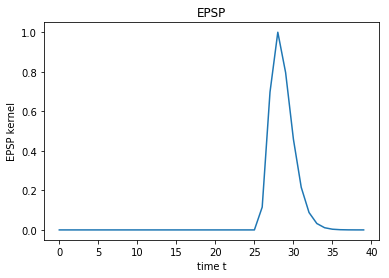

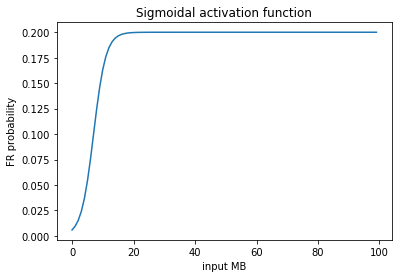

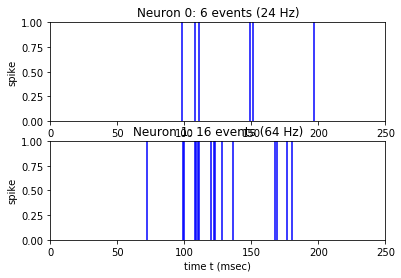

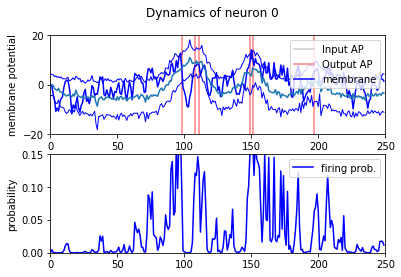

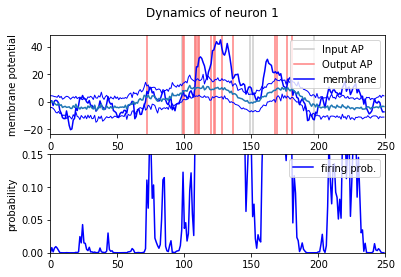

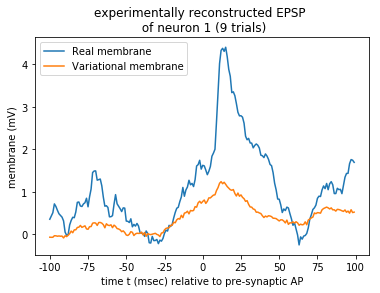

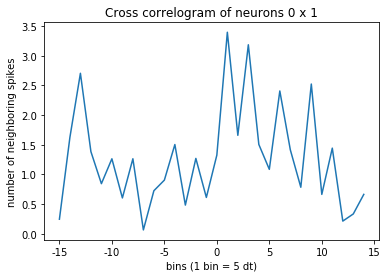

In [447]:
sim_case                        = 0 
output_range = np.arange(-40,40,1.)

if sim_case == 0:
    # simple two-node network (0 --> 1)
    p                           = 2
    adj_mat                     = np.zeros((p,p))
    adj_mat[0,1]                = 1
elif sim_case == 1:
    # transitive three-node network (0 --> 1 --> 2)
    p                           = 3
    adj_mat                     = np.zeros((p,p))
    adj_mat[0,1] = adj_mat[1,2] = 1
else:
    # large sparse/weakly-coupled random network (potentially recurrent)
    p                           = 5
    sparse                      = 0.2
    adj_mat                     = np.zeros((p**2))
    adj_mat[0:int(sparse*p**2)] = 1                                                                                                                                                                                                     
    np.random.shuffle(adj_mat)
    adj_mat                     = adj_mat.reshape((p,p))
    adj_mat[np.diag_indices(p)] = 0


connection_strength     = 0.3

ntime_points            = 250 
time_step               = 0.001
time_period = ntime_points*time_step
time_range              = np.linspace(-time_period/2., time_period/2., ntime_points)
padding_window          = 50

simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period,
                           'padding'                : padding_window}

ntrials_train           = 10
ntrials_test            = 10

simulation                          = sim.integroDifferential_simulator()
(training_samples, testing_samples) = simulation.simulate_spiking_network_dynamics(ntrials_train, 
                                                                                   ntrials_test, 
                                                                                   simulation_params)

plotOn                  = True      

if plotOn:
    
    
    plt.close('all')    
   
    # plot epsp
    plt.figure(); plt.plot(simulation.neuron_functions["epsp"])
    plt.title('EPSP')
    plt.xlabel('time t'); plt.ylabel('EPSP kernel')
    
    # plot activation function
    plt.figure(); plt.plot(simulation.neuron_functions["sigma"](np.arange(-0,100)))
    plt.title('Sigmoidal activation function')
    plt.xlabel('input MB'); plt.ylabel('FR probability')
    
    # plot Bernoulli spike trains of neurons
    trial = 0
    fig = plt.figure()
    for neuron in range(0,p):
        nAP = training_samples["action_potentials"][trial][neuron,:]
        plt.subplot(p,1,neuron+1)
        spikeIDX = np.nonzero(nAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = 'b')
        plt.ylabel('spike');
        plt.title('Neuron %s: %d events (%i Hz)' %(neuron,np.sum(nAP >0),np.round(np.sum(nAP >0)/time_period)))
        plt.gca().set_xlim([0, time_period/time_step]); 
    plt.xlabel('time t (msec)');
        
    # plot stats for neurons
    neurons = [0,1]
    for neuron in neurons:
        fig   = plt.figure()
        nAP   = training_samples["action_potentials"][trial][neuron,:]
        preAP = np.dot(adj_mat[:,neuron]>0, training_samples["action_potentials"][trial]) 
        nMB   = training_samples["membrane_potentials"][trial][neuron,:]
        nFR   = training_samples["firing_probabilities"][trial][neuron,:]
        in_data = np.reshape(training_samples["action_potentials"][trial][neuron,:]*2 - 1., newshape=(1, len(time_range)))
        var_result = get_membrane(in_data, time_range, output_range, spike_forecaster)
        
        plt.subplot(211)
        spikeIDX = np.nonzero(preAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = (0.8, 0.8, 0.8))
        spikeIDX = np.nonzero(nAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = (1.0, 0.5, 0.5))
        plt.xlabel('time t (msec)'); plt.ylabel('membrane potential')
        plt.gcf().suptitle('Dynamics of neuron %s' %neuron)
        plt.gca().set_xlim([0, time_period/time_step]);
        plt.plot(nMB, color = 'b')
        plt.plot(var_result["mean"])
        plt.plot(var_result["mean"] + np.sqrt(var_result["var"]), c ="b", lw = 1)
        plt.plot(var_result["mean"] - np.sqrt(var_result["var"]), c ="b", lw = 1)
        plt.legend(('Input AP','Output AP','membrane'),loc='upper right')
        ax = plt.gca(); leg = ax.get_legend()
        if len(leg.legendHandles) >2:
            leg.legendHandles[0].set_color((0.8, 0.8, 0.8))
            leg.legendHandles[1].set_color((1.0, 0.5, 0.5))
            leg.legendHandles[2].set_color('blue')
            
        plt.subplot(212)
        plt.plot(nFR, color = 'b')
        plt.ylabel('probability')
        plt.legend(('firing prob.',),loc='upper right')
        plt.gca().set_xlim([0, time_period/time_step]);
        plt.gca().set_ylim([0, 0.15]);
        
    # compute ERP in response to pre-synaptic spikes 
    # and cross-correlogram between two neurons
    neurons  = [0,1] 
    average_crossCorr = 0
    average_potential = 2*[0]
    for trial in range(ntrials_train):
        preAP    = training_samples["action_potentials"][trial][neurons[0],:]
        postMB   = training_samples["membrane_potentials"][trial][neurons[1],:]
        postAP   = training_samples["action_potentials"][trial][neurons[1],:]
        window   = 100; template= np.zeros(2*window)   # window for ERP analysis
        crossWin = 15; crossCor = np.zeros(2*crossWin) # number of plotted bins for cross-correlogram
        in_data = np.reshape(training_samples["action_potentials"][trial][neurons[1],:]*2 - 1., newshape=(1, len(time_range)))
        var_result = get_membrane(in_data, time_range, output_range, spike_forecaster)
        var_postMP = var_result["mean"]

        # zero-padd the timeseries to avoid problems with the interval running over the array ends
        for index, pMP in enumerate([postMB, var_postMP]):
            node1IDX    = np.nonzero(np.append(np.append(np.zeros(window),preAP),np.zeros(window)))[0]
            postMBpadd  =            np.append(np.append(np.zeros(window),pMP),np.zeros(window))
            node2IDX    = time_step*np.nonzero(postAP)[0]
            node2IDX    = np.append(np.array(0.0),np.append(node2IDX,np.array(time_period)))

            binSize     = 5                                         # size of histogram bins in units of dt
            binNum      = np.int((time_period/time_step)/binSize)   # resulting resolution of bins

            # for each presynaptic unit spike ...
            for ref in node1IDX[node1IDX>0]:
                # ... collect event-related postsynaptic membrane perturbations
                template += postMBpadd[(ref-window):(ref+window)]

                # compute histogram of postsynaptic spike times for cross correlograms
                # ("edges" contains every bin's left interval ending)
                hist, edges = np.histogram(node2IDX, bins=binNum)#dt*np.nonzero(n2AP)[0], bins=binNum)

                # remove the endpoint counts previously added in node2IDX
                hist[0] -=1; hist[-1] -=1

                # find first bin whose left edge comes after the (presynaptic) reference spike
                # (remove zero-padd window of node1IDX and increment index for subsequent zero-padd of length crossWin)
                refBin = crossWin + np.min(np.nonzero(edges >= time_step*(ref-window)))

                # zero-padd the histogram to avoid problems with the interval running over the array ends
                hist  = np.append(np.append(np.zeros(crossWin),hist),np.zeros(crossWin))

                # remember the neighboring spikes (centered around refBin)
                crossCor += hist[refBin-crossWin:refBin+crossWin]


            # normalize epsp template   
            num_spikes = np.sum(node1IDX>-1)
            template = template/num_spikes if num_spikes>0 else template
            average_crossCorr += crossCor
            average_potential[index] += template
        
        average_crossCorr = average_crossCorr/float(ntrials_train)
        average_potential[0] = average_potential[0]/float(ntrials_train)
        average_potential[1] = average_potential[1]/float(ntrials_train)
    
    fig = plt.figure()
    plt.plot(average_potential[0], label="Real membrane")
    plt.plot(average_potential[1], label="Variational membrane")
    plt.title('experimentally reconstructed EPSP \n of neuron %i (%i trials)' %(neurons[1],np.sum(node1IDX>-1)))
    plt.xlabel('time t (msec) relative to pre-synaptic AP'); plt.ylabel('membrane (mV)')
    xTick_posit = np.arange(0,200+1,25)
    xTick_label = np.arange(-100,100+1,25)
    plt.xticks(xTick_posit, xTick_label)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure();
    plt.plot(average_crossCorr)
    plt.title('Cross correlogram of neurons %i x %i' %(neurons[0],neurons[1]))
    plt.xlabel('bins (1 bin = %i dt)' %binSize); plt.ylabel('number of neighboring spikes')
    xTick_posit = np.arange(0,30+1,5)
    xTick_label = np.arange(-15,15+1,5)
    plt.xticks(xTick_posit, xTick_label)
    plt.show()

In [448]:
output_range = np.arange(-40,40,1.)
trial = 4
data = np.reshape(training_samples["action_potentials"][trial][0,:]*2 - 1., newshape=(1, len(time_range)))
result = get_membrane(data, time_range, output_range, spike_forecaster)

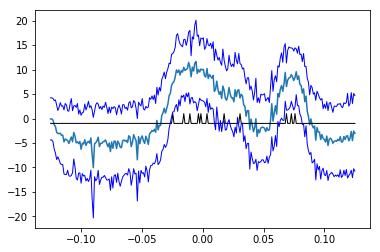

In [449]:
plt.plot(time_range, result["mean"])
plt.plot(time_range, data.flatten(), c ="k", lw = 1)
plt.plot(time_range, result["mean"] + np.sqrt(result["var"]), c ="b", lw = 1)
plt.plot(time_range, result["mean"] - np.sqrt(result["var"]), c ="b", lw = 1)

In [450]:
from gp_cake import gpcake 
from gp_cake import utility
from gp_cake import diagnostics 
reload(gpcake)
reload(utility)
reload(diagnostics)

cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 5
dynamic_parameters_range["relaxation_constant"]["min"] = 65
dynamic_parameters_range["relaxation_constant"]["max"] = 70
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 1.
dynamic_parameters_range["amplitude"]["min"] = 2.
dynamic_parameters_range["amplitude"]["max"] = 3.

cake.learn_dynamic_parameters(training_samples['membrane_potentials'], dynamic_parameters_range)

gp_cake/diagnostics.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/vol/opt

In [451]:
cake.set_covariance_parameters(time_scale = 0.01,     
                               time_shift = 0.025,      
                               spectral_smoothing = 100*np.pi,
                               number_sources = p,
                               noise_level = 0.05)

In [452]:
cake.parallelthreads=1
connectivity = cake.run_spike_membrane_analysis(spike_data=training_samples['action_potentials'],
                                                membrane_data=training_samples['membrane_potentials'])

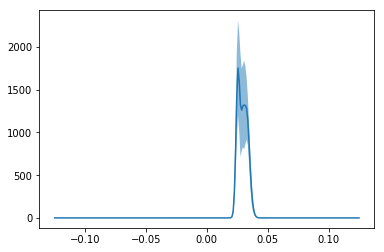

In [453]:
mean_kernels01 = np.mean(connectivity,axis=0)[0,1,:]
sd_kernels01 = np.std(connectivity,axis=0)[0,1,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, mean_kernels01.flatten())
plt.fill_between(time_range, mean_kernels01 - sd_kernels01*1.96, mean_kernels01 + sd_kernels01*1.96, alpha=0.5)

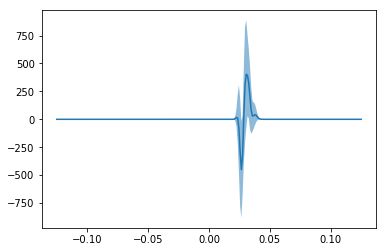

In [454]:
mean_kernels10 = np.mean(connectivity,axis=0)[1,0,:]
sd_kernels10 = np.std(connectivity,axis=0)[1,0,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, mean_kernels10.flatten())
plt.fill_between(time_range, mean_kernels10 - sd_kernels10*1.96, mean_kernels10 + sd_kernels10*1.96, alpha=0.5)

In [455]:

estimated_membrane = [np.concatenate(tuple([np.reshape(np.array(get_membrane(np.reshape(trial[n,:]*2 - 1., 
                                                                                        newshape=(1, 
                                                                                                  len(time_range))), 
                                                                             time_range, 
                                                                             output_range, 
                                                                             spike_forecaster)["mean"]), 
                                                       newshape = (1, len(time_range))) 
                                            for n in range(p)]), axis=0)
                      for trial in training_samples['action_potentials']]

In [456]:
cake.parallelthreads=1
est_connectivity = cake.run_spike_membrane_analysis(spike_data=training_samples['action_potentials'],
                                                    membrane_data=estimated_membrane)

(-300, 300)

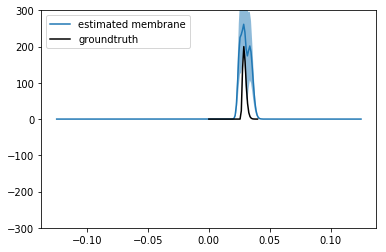

In [457]:
est_mean_kernels01 = np.mean(est_connectivity,axis=0)[0,1,:]
est_sd_kernels01 = np.std(est_connectivity,axis=0)[0,1,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, est_mean_kernels01.flatten(), label = "estimated membrane")
plt.fill_between(time_range, est_mean_kernels01 - est_sd_kernels01*1.96, 
                             est_mean_kernels01 + est_sd_kernels01*1.96, alpha=0.5)
#plt.plot(time_range, mean_kernels01.flatten(), c = "r", label = "real membrane")
#plt.fill_between(time_range, mean_kernels01 - sd_kernels01, mean_kernels01 + sd_kernels01, alpha=0.25, color = "r")
epsp_time = np.linspace(0, 0.04,40)
plt.plot(epsp_time, simulation.neuron_functions["epsp"]*200, c = "k", label = "groundtruth")
plt.legend(loc="best")
plt.ylim(-300,300)

(-300, 300)

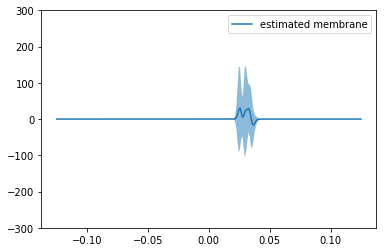

In [458]:
est_mean_kernels10 = np.mean(est_connectivity,axis=0)[1,0,:]
est_sd_kernels10 = np.std(est_connectivity,axis=0)[1,0,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, est_mean_kernels10.flatten(), label = "estimated membrane")
plt.fill_between(time_range, est_mean_kernels10 - est_sd_kernels10*1.96, 
                             est_mean_kernels10 + est_sd_kernels10*1.96, alpha=0.5)
#plt.plot(time_range, mean_kernels10.flatten(), c = "r", label = "real membrane")
#plt.fill_between(time_range, mean_kernels10 - sd_kernels10, mean_kernels10 + sd_kernels10, alpha=0.25, color = "r")
plt.legend(loc="best")
#plt.ylim(-150,150)
plt.ylim(-300,300)

In [459]:
cake_hawkes = gpcake.gpcake()
cake_hawkes.initialize_time_parameters(time_step, time_period, ntime_points)
cake_hawkes.dynamic_parameters["number_sources"] = p
cake_hawkes.dynamic_type = "Relaxation"

dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 1.
dynamic_parameters_range["relaxation_constant"]["min"] = 3000.
dynamic_parameters_range["relaxation_constant"]["max"] = 3002.
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 1.
dynamic_parameters_range["amplitude"]["min"] = 1.
dynamic_parameters_range["amplitude"]["max"] = 1.1

cake_hawkes.learn_dynamic_parameters(training_samples['firing_probabilities'], dynamic_parameters_range)

In [460]:
cake_hawkes.parallelthreads=1
haw_connectivity = cake.run_spike_membrane_analysis(spike_data=training_samples['action_potentials'],
                                                    membrane_data=training_samples['firing_probabilities'])

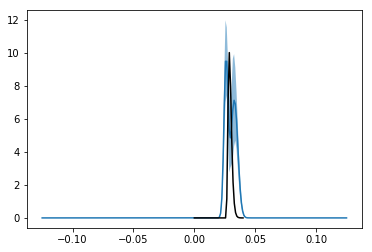

In [461]:
haw_mean_kernels01 = np.mean(haw_connectivity,axis=0)[0,1,:]
haw_sd_kernels01 = np.std(haw_connectivity,axis=0)[0,1,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, haw_mean_kernels01.flatten())
plt.fill_between(time_range, haw_mean_kernels01 - haw_sd_kernels01*1.96, 
                 haw_mean_kernels01 + haw_sd_kernels01*1.96, alpha=0.5)
plt.plot(epsp_time, simulation.neuron_functions["epsp"]*10, c = "k", label = "groundtruth")

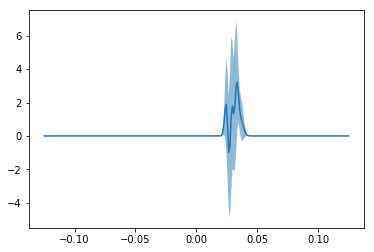

In [462]:
haw_mean_kernels10 = np.mean(haw_connectivity,axis=0)[1,0,:]
haw_sd_kernels10 = np.std(haw_connectivity,axis=0)[1,0,:]/np.sqrt(float(ntrials_train))
plt.plot(time_range, haw_mean_kernels10.flatten())
plt.fill_between(time_range, haw_mean_kernels10 - haw_sd_kernels10*1.96, 
                 haw_mean_kernels10 + haw_sd_kernels10*1.96, alpha=0.5)